In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('model_data.csv')

In [3]:
df

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,...,2P%,FT%,TmNetRtg,Continuity,Next Rtg,Next Cont,Next WS,Veteran Value,VV Class,Player Level
0,1,1997,Vinny Del,SG,30.0,SAS,72.0,2243.0,14.4,0.529,...,0.501,0.868,-8.8,0.75,4.4,0.59,3.7,2903.225806,0,0
1,3,1997,Avery Johnson,PG,31.0,SAS,76.0,2472.0,15.0,0.517,...,0.487,0.690,-8.8,0.75,4.4,0.59,6.7,14558.823529,0,0
2,7,1997,Charles Barkley,PF,33.0,HOU,53.0,2009.0,23.0,0.581,...,0.569,0.694,4.7,0.46,-0.9,0.95,8.6,14.000000,0,2
3,8,1997,Clyde Drexler,SG,34.0,HOU,62.0,2271.0,19.9,0.548,...,0.493,0.750,4.7,0.46,-0.9,0.95,6.8,7.423895,0,2
4,9,1997,Mario Elie,SF,33.0,HOU,78.0,2687.0,14.3,0.662,...,0.572,0.896,4.7,0.46,-0.9,0.95,3.8,2.079266,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,1393,2020,Dwight Howard,C,34.0,LAL,69.0,1306.0,18.7,0.696,...,0.732,0.514,5.6,0.52,5.5,0.58,4.0,0.068878,0,0
798,1394,2020,LeBron James,PG,35.0,LAL,67.0,2316.0,25.5,0.577,...,0.564,0.693,5.6,0.52,2.9,0.60,5.6,1.125000,0,3
799,1396,2020,Justin Holiday,SG,30.0,IND,73.0,1826.0,12.1,0.585,...,0.477,0.791,1.9,0.47,0.1,0.88,3.1,3.617225,0,1
800,1400,2020,Paul Millsap,PF,34.0,DEN,51.0,1240.0,16.9,0.591,...,0.500,0.816,2.2,0.80,4.8,0.70,3.2,-1012.987013,1,0


In [4]:
df[df['Player']=='Ray Allen']

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,...,2P%,FT%,TmNetRtg,Continuity,Next Rtg,Next Cont,Next WS,Veteran Value,VV Class,Player Level
380,691,2008,Ray Allen,SG,32.0,BOS,73.0,2624.0,16.4,0.584,...,0.485,0.907,10.8,0.50,7.9,0.94,11.1,387.552501,0,2
412,743,2009,Ray Allen,SG,33.0,BOS,79.0,2876.0,17.3,0.624,...,0.542,0.952,7.9,0.94,3.7,0.79,7.9,1.844146,0,2
444,794,2010,Ray Allen,SG,34.0,BOS,80.0,2819.0,15.2,0.601,...,0.556,0.913,3.7,0.79,5.7,0.76,10.0,1436.879918,0,1
478,851,2011,Ray Allen,SG,35.0,BOS,80.0,2890.0,16.4,0.615,...,0.520,0.881,5.7,0.76,2.6,0.65,4.7,1.026150,0,1
512,907,2012,Ray Allen,SG,36.0,BOS,46.0,1565.0,14.8,0.607,...,0.463,0.915,2.6,0.65,8.2,0.82,5.4,3207.855974,0,1
546,955,2013,Ray Allen,SG,37.0,MIA,79.0,2035.0,14.7,0.599,...,0.480,0.886,8.2,0.82,5.1,0.91,4.1,1.570356,0,1


## Pre-Processing

In [5]:
df.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', '3P%', '2P%',
       'FT%', 'TmNetRtg', 'Continuity', 'Next Rtg', 'Next Cont', 'Next WS',
       'Veteran Value', 'VV Class', 'Player Level'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

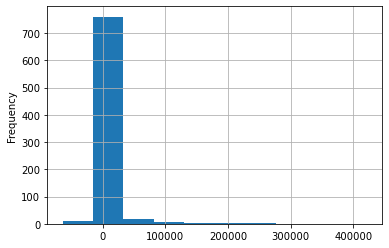

In [6]:
df['Veteran Value'].plot.hist(grid=True)

In [7]:
# calculate summary statistics
data = df['Veteran Value']
data_mean, data_std = np.mean(data), np.std(data)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
lower, upper = -30000,30000

In [8]:
outliers = [x[0] for x in enumerate(df['Veteran Value']) if x[1] < lower or x[1] > upper]
outliers

[17,
 21,
 24,
 91,
 101,
 128,
 129,
 137,
 140,
 190,
 219,
 245,
 248,
 256,
 271,
 398,
 438,
 439,
 440,
 533,
 536,
 564,
 580,
 599,
 606,
 640,
 648,
 649,
 666,
 669,
 671,
 680,
 682,
 683,
 715,
 719,
 772,
 785,
 789]

In [9]:
df.drop(index=outliers,inplace=True)

<AxesSubplot:ylabel='Frequency'>

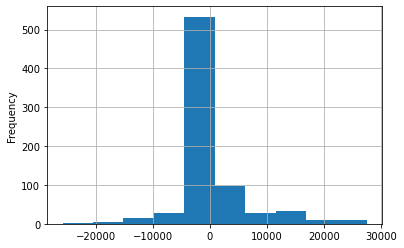

In [10]:
df['Veteran Value'].plot.hist(grid=True)

[  2.   4.  15.  29. 533.  98.  29.  32.  10.  11.] [-25787.54578755 -20461.87762854 -15136.20946954  -9810.54131054
  -4484.87315154    840.79500746   6166.46316646  11492.13132546
  16817.79948447  22143.46764347  27469.13580247]


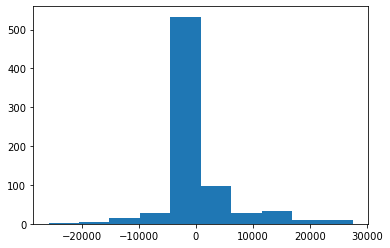

In [11]:
n, bins, patches = plt.hist(df['Veteran Value'])
print(n,bins)

In [12]:
def findPercentile(veteran_values, num_classes):
    percentiles = []
    inc = 100 / num_classes
#     percentiles = [0]
    start = inc
    for _ in range(num_classes-1):
        percentiles.append(np.percentile(veteran_values, start))

        start += inc
#     percentiles.append(100)
    return percentiles

In [13]:
percentiles = findPercentile(df['Veteran Value'],5)
percentiles

[-275.30838514820164, 1.707162643450732, 7.84384615384615, 1349.1435377136067]

In [14]:
target = df['Veteran Value']

def getClass(vv):
    if vv < percentiles[0]:
        return 0
    elif percentiles[0] <= vv < percentiles[1]:
        return 1
    elif percentiles[1] <= vv < percentiles[2]:
        return 2
    elif percentiles[2] <= vv < percentiles[3]:
        return 3
    elif percentiles[3] < vv:
        return 4

    
df['VV Class'] = [getClass(vv) for vv in df['Veteran Value']]
target_class = df['VV Class']

In [15]:
df['Veteran Value'].describe()

count      763.000000
mean       936.523763
std       5764.263505
min     -25787.545788
25%          0.000000
50%          2.989130
75%        527.392637
max      27469.135802
Name: Veteran Value, dtype: float64

In [16]:
df.drop(['Unnamed: 0','Age','Year','Player','Pos','Tm','Next WS','WS','Next Rtg','TmNetRtg','Continuity', 'Veteran Value', 'VV Class'], axis=1, inplace=True)

In [17]:
df.columns

Index(['G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', '3P%',
       '2P%', 'FT%', 'Next Cont', 'Player Level'],
      dtype='object')

In [18]:
#try scaling values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [19]:
'''
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import StackingClassifier

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

clf = LogisticRegression(tol=1e-4, max_iter=1000, random_state=0)
n_neighbors = 15
neigh = KNeighborsClassifier(n_neighbors)
rf = RandomForestClassifier(n_estimators=270, max_depth=50, min_samples_leaf=10, min_samples_split = 10,verbose=False)
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=2**6, max_depth=10), 
                             n_estimators=250, learning_rate=0.5)
mlpc = MLPClassifier(hidden_layer_sizes=(1000,200,30,5),activation='relu',learning_rate_init=0.001,batch_size=256,max_iter=400,verbose=False)

estimator = [] 
estimator.append(('RFC',rf))
estimator.append(('ABC',abc))
estimator.append(('MLP',mlpc))
estimator.append(('LRC',clf))
estimator.append(('KNC',neigh))
vot_soft = VotingClassifier(estimators = estimator, voting='soft', verbose=False) 

temp = []
models = [clf,neigh,rf,abc,mlpc,vot_soft]
for m in models:
    cv_results = cross_validate(m, scaled_data, target_class, cv=kf, scoring='roc_auc_ovr', return_train_score=False)
    temp.append(cv_results)
'''

"\nfrom sklearn.model_selection import KFold, cross_validate\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import AdaBoostClassifier\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.ensemble import VotingClassifier \nfrom sklearn.ensemble import StackingClassifier\n\nn_splits = 10\nkf = KFold(n_splits=n_splits, shuffle=True)\n\nclf = LogisticRegression(tol=1e-4, max_iter=1000, random_state=0)\nn_neighbors = 15\nneigh = KNeighborsClassifier(n_neighbors)\nrf = RandomForestClassifier(n_estimators=270, max_depth=50, min_samples_leaf=10, min_samples_split = 10,verbose=False)\nabc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=2**6, max_depth=10), \n                             n_estimators=250, learning_rate=0.5)

In [20]:
'''
scores = []
for i in temp:
    scores.append(np.average(i['test_score']))
scores
'''

"\nscores = []\nfor i in temp:\n    scores.append(np.average(i['test_score']))\nscores\n"

In [21]:
#rf.fit(scaled_data,target_class)

In [22]:
#rf.predict_proba(scaled_data)

In [23]:
#from sklearn import metrics
#metrics.roc_auc_score(target_class,rf.predict_proba(scaled_data),multi_class='ovr')

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, target_class.values, random_state=42,test_size=0.1)

### Logistic Regression Classifier

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
clf = LogisticRegression(tol=1e-4, max_iter=1000, random_state=0).fit(xtrain, ytrain)
clf.predict(xtest)
clf.predict_proba(xtest)
scores = cross_val_score(clf, xtest, ytest, cv=5)
print(scores.mean())

0.3475


In [26]:
metrics.roc_auc_score(ytest,clf.predict_proba(xtest),multi_class='ovr')

0.6404726173617129

### KNN Classifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

n_neighbors=15
neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=15)

In [28]:
metrics.roc_auc_score(ytest,neigh.predict_proba(xtest),multi_class='ovr')

0.6587190356639322

### Random Forests Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=270, max_depth=50, min_samples_leaf=10, min_samples_split = 10,verbose=False)
rf.fit(xtrain, ytrain)
rf.predict_proba(xtest)

array([[0.25993021, 0.16452712, 0.27109401, 0.21083219, 0.09361647],
       [0.1563281 , 0.23473412, 0.23561205, 0.19718565, 0.17614008],
       [0.14215127, 0.22965359, 0.29626877, 0.21034067, 0.12158569],
       [0.17349849, 0.21904722, 0.25623649, 0.19147401, 0.15974378],
       [0.17273646, 0.08158929, 0.09244835, 0.18488097, 0.46834493],
       [0.18960756, 0.24434574, 0.18422546, 0.18982779, 0.19199346],
       [0.18393103, 0.11493437, 0.13719502, 0.17206222, 0.39187736],
       [0.26034056, 0.2004245 , 0.25076581, 0.19825025, 0.09021887],
       [0.26770738, 0.25468636, 0.1632447 , 0.19369469, 0.12066687],
       [0.16967029, 0.20735851, 0.35453602, 0.21131039, 0.05712479],
       [0.18189454, 0.2789041 , 0.31042408, 0.1877507 , 0.04102658],
       [0.27332476, 0.16512949, 0.20265885, 0.22509053, 0.13379637],
       [0.3106325 , 0.30002709, 0.15599766, 0.15275093, 0.08059181],
       [0.12407121, 0.10536786, 0.1099687 , 0.15987015, 0.50072208],
       [0.16292818, 0.37039293, 0.

In [30]:
metrics.roc_auc_score(ytest,rf.predict_proba(xtest),multi_class='ovr')

0.6683126232486846

### Boosted Classifier


In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=2**6, max_depth=10), 
                         n_estimators=250, learning_rate=0.5)
abc.fit(xtrain, ytrain)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         min_samples_split=64),
                   learning_rate=0.5, n_estimators=250)

In [32]:
metrics.roc_auc_score(ytest,abc.predict_proba(xtest),multi_class='ovr')

0.6699518395612327

### Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(1000,200,30,5),activation='relu',learning_rate_init=0.001,batch_size=256, verbose=False,max_iter=400)
mlpc.fit(xtrain, ytrain)

MLPClassifier(batch_size=256, hidden_layer_sizes=(1000, 200, 30, 5),
              max_iter=400)

In [34]:
metrics.roc_auc_score(ytest,mlpc.predict_proba(xtest),multi_class='ovr')

0.563194081401475

### Voting Classifier

In [35]:
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import StackingClassifier

estimator = [] 
estimator.append(('RFC',rf))
estimator.append(('LRC',clf))
estimator.append(('ABC',abc))
estimator.append(('MLP',mlpc))
estimator.append(('KNC',neigh))

vot_soft = VotingClassifier(estimators = estimator, voting='soft', verbose=False) 
vot_soft.fit(xtrain, ytrain)


VotingClassifier(estimators=[('RFC',
                              RandomForestClassifier(max_depth=50,
                                                     min_samples_leaf=10,
                                                     min_samples_split=10,
                                                     n_estimators=270,
                                                     verbose=False)),
                             ('LRC',
                              LogisticRegression(max_iter=1000,
                                                 random_state=0)),
                             ('ABC',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                                       min_samples_split=64),
                                                 learning_rate=0.5,
                                                 n_estimators=250)),
                             ('MLP',
                

In [36]:
metrics.roc_auc_score(ytest,vot_soft.predict_proba(xtest),multi_class='ovr')

0.6794088290484478

## Test on Veterans of 2021-2022 Season

Data Cleaning for NBA 2021-2022

In [37]:
import pandas as pd
import numpy as np
data = pd.read_csv('compiled.csv')

In [38]:
data2 = data[data['Year']==2021]
data2 = data2.copy()

In [39]:
data2

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,OWS,DWS,WS,WS/48,OBPM,DBPM,3P%,2P%,FT%,TmNetRtg
1461,2021,Carmelo Anthony,PF,36.0,POR,69.0,1690.0,14.6,0.547,0.418,...,1.7,0.8,2.6,0.073,0.1,-1.6,0.409,0.429,0.890,1.8
1462,2021,Robert Covington,PF,30.0,POR,70.0,2243.0,11.2,0.553,0.699,...,1.4,2.4,3.7,0.080,-1.5,1.2,0.379,0.451,0.806,1.8
1463,2021,Damian Lillard,PG,30.0,POR,67.0,2398.0,25.6,0.623,0.528,...,9.6,0.8,10.4,0.209,7.4,-1.6,0.391,0.519,0.928,1.8
1464,2021,Will Barton,SF,30.0,DEN,56.0,1736.0,11.8,0.538,0.423,...,0.7,1.5,2.2,0.061,-0.8,-1.2,0.381,0.459,0.785,4.8
1465,2021,JaMychal Green,PF,30.0,DEN,58.0,1120.0,13.6,0.590,0.529,...,1.4,1.2,2.6,0.110,-0.4,-1.6,0.399,0.534,0.807,4.8
1466,2021,Paul Millsap,PF,35.0,DEN,56.0,1162.0,16.4,0.565,0.357,...,1.7,1.6,3.2,0.133,0.4,0.1,0.343,0.550,0.724,4.8
1467,2021,Nicolas Batum,SF,32.0,LAC,67.0,1835.0,12.9,0.617,0.660,...,2.7,2.3,5.0,0.132,0.5,1.0,0.404,0.579,0.828,6.1
1468,2021,Paul George,SF,30.0,LAC,54.0,1821.0,20.5,0.598,0.437,...,3.0,2.3,5.3,0.139,4.0,-0.4,0.411,0.510,0.868,6.1
1469,2021,Reggie Jackson,SG,30.0,LAC,67.0,1544.0,14.2,0.576,0.482,...,2.3,1.4,3.7,0.115,0.5,-0.5,0.433,0.465,0.817,6.1
1470,2021,Marcus Morris,PF,31.0,LAC,57.0,1502.0,14.5,0.614,0.507,...,2.1,1.5,3.6,0.115,0.9,-1.0,0.473,0.472,0.820,6.1


In [40]:
data1 = pd.read_csv('continuity.csv')

In [41]:
data1

,Year,Tm,Continuity
0,2022,ATL,85
1,2022,BOS,79
2,2022,CHA,67
3,2022,CHI,51
4,2022,CLE,58
...,...,...,...
768,1997,SAC,87
769,1997,SAS,75
770,1997,TOR,50
771,1997,UTA,92


In [42]:
next_cont = []
for index, row in data2.iterrows():
    current_team = row['Tm']
    next_year = row['Year'] + 1
    
    try:
        continuity = data1.loc[(data1['Tm'] == current_team) & (data1['Year'] == 2022)].iloc[0]['Continuity'] 
        next_cont.append(continuity)
    except:
        next_cont.append(math.nan)

In [43]:
data2['Next Cont'] = next_cont

In [44]:
data2['Next Cont'] = data2['Next Cont']/100

In [45]:
data2

,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,OBPM,DBPM,3P%,2P%,FT%,TmNetRtg,Next Cont
1461,2021,Carmelo Anthony,PF,36.0,POR,69.0,1690.0,14.6,0.547,0.418,...,0.8,2.6,0.073,0.1,-1.6,0.409,0.429,0.890,1.8,0.80
1462,2021,Robert Covington,PF,30.0,POR,70.0,2243.0,11.2,0.553,0.699,...,2.4,3.7,0.080,-1.5,1.2,0.379,0.451,0.806,1.8,0.80
1463,2021,Damian Lillard,PG,30.0,POR,67.0,2398.0,25.6,0.623,0.528,...,0.8,10.4,0.209,7.4,-1.6,0.391,0.519,0.928,1.8,0.80
1464,2021,Will Barton,SF,30.0,DEN,56.0,1736.0,11.8,0.538,0.423,...,1.5,2.2,0.061,-0.8,-1.2,0.381,0.459,0.785,4.8,0.92
1465,2021,JaMychal Green,PF,30.0,DEN,58.0,1120.0,13.6,0.590,0.529,...,1.2,2.6,0.110,-0.4,-1.6,0.399,0.534,0.807,4.8,0.92
1466,2021,Paul Millsap,PF,35.0,DEN,56.0,1162.0,16.4,0.565,0.357,...,1.6,3.2,0.133,0.4,0.1,0.343,0.550,0.724,4.8,0.92
1467,2021,Nicolas Batum,SF,32.0,LAC,67.0,1835.0,12.9,0.617,0.660,...,2.3,5.0,0.132,0.5,1.0,0.404,0.579,0.828,6.1,0.81
1468,2021,Paul George,SF,30.0,LAC,54.0,1821.0,20.5,0.598,0.437,...,2.3,5.3,0.139,4.0,-0.4,0.411,0.510,0.868,6.1,0.81
1469,2021,Reggie Jackson,SG,30.0,LAC,67.0,1544.0,14.2,0.576,0.482,...,1.4,3.7,0.115,0.5,-0.5,0.433,0.465,0.817,6.1,0.81
1470,2021,Marcus Morris,PF,31.0,LAC,57.0,1502.0,14.5,0.614,0.507,...,1.5,3.6,0.115,0.9,-1.0,0.473,0.472,0.820,6.1,0.81


In [46]:
starter = data2.loc[(data2['WS/48']>=0.1) & (data2['MP']/data2['G']>25),'Player']
all_star = data2.loc[(data2['WS/48']>=0.15) & (data2['MP']/data2['G']>30) & (data2['USG%'] > 20),'Player']
super_star = data2.loc[(data2['WS/48']>=0.15) & (data2['MP']/data2['G']>30) & (data2['USG%'] > 30),'Player']
player_level = []
for p in data2['Player']:
    if p in list(super_star):
        player_level.append(3)
    elif p in list(all_star) and p not in list(super_star):
        player_level.append(2)
    elif p in list(starter) and p not in list(super_star) and p not in list(all_star):
        player_level.append(1)
    else:
        player_level.append(0)
data2['Player Level'] = player_level


In [47]:
data2_copy = data2.copy()
data2.drop(['Age','Year','Player','Pos','Tm','WS','TmNetRtg'], axis=1, inplace=True)
len(data2.columns)

23

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data2)

In [52]:
vv21 = vot_soft.predict(scaled_data)

In [53]:
from collections import defaultdict
preds = defaultdict(list)
for t in zip(data2_copy['Player'], vv21,data2_copy['Player Level']):
    preds[t[2]].append(tuple((t[0], t[1])))
preds = sorted(preds.items(),key=lambda x: (x[1][1],x[0]),reverse=True)
for i in preds:
    print(i,'\n')

'''
for k,v in preds.items():
    print(k,":",v)
    print('\n')
'''

(3, [('Damian Lillard', 0), ('Stephen Curry', 1), ('Kevin Durant', 4), ('LeBron James', 2)]) 

(0, [('Carmelo Anthony', 1), ('Robert Covington', 2), ('Will Barton', 4), ('JaMychal Green', 4), ('Paul Millsap', 4), ('Reggie Jackson', 1), ('Kent Bazemore', 4), ('Eric Bledsoe', 3), ('Goran Dragiƒá', 4), ('Andre Iguodala', 4), ('Dwight Howard', 0), ('Rudy Gay', 4), ('Patty Mills', 1), ('DeAndre Jordan', 0), ('Wayne Ellington', 4), ('Danilo Gallinari', 4), ('Justin Holiday', 1), ('Wesley Matthews', 4), ('Markieff Morris', 4), ('Robin Lopez', 0), ('Russell Westbrook', 3), ('Ricky Rubio', 4), ('Garrett Temple', 4), ('Thaddeus Young', 2), ('John Wall', 4)]) 

(1, [('Nicolas Batum', 2), ('Paul George', 2), ('Marcus Morris', 1), ('Draymond Green', 2), ('Bojan Bogdanoviƒá', 1), ('Mike Conley', 3), ('Joe Ingles', 1), ('Seth Curry', 1), ('Danny Green', 2), ('Jeff Green', 0), ('Mason Plumlee', 0), ('Brook Lopez', 1), ('Kyle Lowry', 4), ('Nikola Vuƒçeviƒá', 4), ('Kemba Walker', 4)]) 

(2, [('Jimmy But

'\nfor k,v in preds.items():\n    print(k,":",v)\n    print(\'\n\')\n'

In [54]:
with open('results.txt', 'a') as file:
    for i in preds:
        file.write(str(i))
        file.write('\n')
    file.write('\n')
    file.close()